In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import PIL
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

In [3]:
os.mkdir("/kaggle/working/bt_images")
os.mkdir("/kaggle/working/bt_images/1")
os.mkdir("/kaggle/working/bt_images/2")
os.mkdir("/kaggle/working/bt_images/3")

3064 files successfully saved


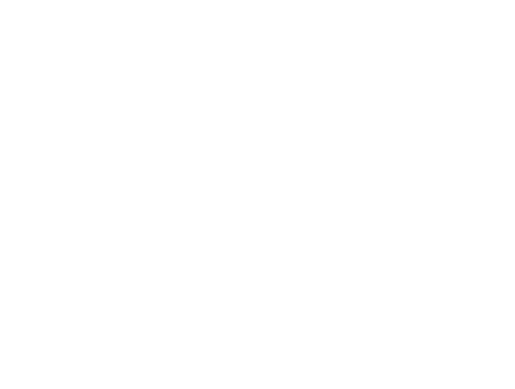

In [4]:
labels=[]
border=[]
filename = None

for filename in range(1, 3065):
  with h5py.File('/kaggle/input/figshare-brain-tumor-dataset/dataset/data/{}.mat'.format(filename), 'r') as f:
      img = f['cjdata']['image']
      label = f['cjdata']['label'][0][0]
     
     
      labels.append(int(label))
      img = np.array(img, dtype=np.float32)
      
      plt.axis('off')
      
      plt.imsave("/kaggle/working/bt_images/{}/{}.jpg".format(str(int(label)),filename), img, cmap='gray')
      
      
print("{} files successfully saved".format(filename))

In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/kaggle/working/bt_images', output="/kaggle/working/output", seed=1337, ratio=(.8, 0.2,0.0)) 

Copying files: 3064 files [00:00, 6498.39 files/s]


In [6]:
#packages for notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [7]:
rotation_angles = [45, 90, 135, 180, 225, 270, 315]
    
    # Define sigma values for Gaussian Blur
sigma_values = [0.25, 0.5, 1.0, 2.0]
    
    # Define lightness values for sharpening
lightness_values = [0.5, 1.0, 1.5, 2.0]
    
    # Define transformations
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomChoice([
            transforms.RandomRotation(angle) for angle in rotation_angles
        ]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=23, sigma=(sigma, sigma)) for sigma in sigma_values
        ], p=0.5),
        transforms.RandomApply([
            transforms.Lambda(lambda img: transforms.functional.adjust_sharpness(img, lightness)) 
            for lightness in lightness_values
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [8]:
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In [9]:
#os.rmdir('/kaggle/working/output/train/0')
# os.rmdir('/kaggle/working/output/val/0')

In [10]:
dataset_path="/kaggle/working/output"
batch_size=64
train_dataset = ImageFolder(dataset_path+"/train", transform=transform)
val_dataset = ImageFolder(dataset_path+"/val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1)  # Convolutional Layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # Convolutional Layer 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Convolutional Layer 3
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Convolutional Layer 4
        
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # Fully Connected Layer 1
        self.fc2 = nn.Linear(1024, 3)  # Fully Connected Layer 2
        
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Conv1
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max Pooling 1
        
        x = F.relu(self.conv2(x))  # Conv2
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max Pooling 2
        
        x = F.relu(self.conv3(x))  # Conv3
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max Pooling 3
        
        x = F.relu(self.conv4(x))  # Conv4
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max Pooling 4
        
#         x = self.flatten(x)# Flatten
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))  # FC1
        x = self.dropout(x)
        x = self.fc2(x)  # FC2
        
        return F.softmax(x, dim=1)  # Softmax

# Initialize the model
resnet_model = CNN()
resnet_model.cuda()
print(resnet_model)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [12]:
# # instantiate transfer learning model
# resnet_model = models.resnet50(pretrained=True)

# # set all parameters as not trainable
# for param in resnet_model.parameters():
#     param.requires_grad = False

# # get input of fc layer
# n_inputs = resnet_model.fc.in_features

# # redefine fc layer / top layer / head for our classification problem
# resnet_model.fc = nn.Sequential(
#     nn.Linear(n_inputs, 2048),
#     nn.SELU(),
#     nn.Dropout(p=0.4),
#     nn.Linear(2048, 1024),
#     nn.SELU(),
#     nn.Dropout(p=0.4),
#     nn.Linear(1024, 512),
#     nn.SELU(),
#     nn.Dropout(p=0.4),
#     nn.Linear(512, 256),
#     nn.SELU(),
#     nn.Dropout(p=0.4),
#     nn.Linear(256, 3)  # Assuming 4 classes
# )

# # Make only the last 2 layers (fc layer and the final activation) trainable
# for name, child in resnet_model.named_children():
#     if name == 'fc'or name=='layer4':
#         for param in child.parameters():
#             param.requires_grad = True

# # set model to run on GPU or CPU based on availability (not shown in your code)
# resnet_model.cuda()
# # print the transfer
# print(resnet_model)

In [13]:
# import torch
# import torch.nn as nn

# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
#         self.relu1 = nn.ReLU()
#         self.batchnorm1 = nn.BatchNorm2d(32)
        
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#         self.relu2 = nn.ReLU()
#         self.batchnorm2 = nn.BatchNorm2d(64)
        
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3)
#         self.relu3 = nn.ReLU()
#         self.batchnorm3 = nn.BatchNorm2d(96)
        
#         self.conv4 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3)
#         self.relu4 = nn.ReLU()
#         self.batchnorm4 = nn.BatchNorm2d(128)
        
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=3)
#         self.relu5 = nn.ReLU()
#         self.batchnorm5 = nn.BatchNorm2d(160)
        
#         self.conv6 = nn.Conv2d(in_channels=160, out_channels=192, kernel_size=3)
#         self.relu6 = nn.ReLU()
#         self.batchnorm6 = nn.BatchNorm2d(192)
        
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
#         self.conv7 = nn.Conv2d(in_channels=192, out_channels=224, kernel_size=3)
#         self.relu7 = nn.ReLU()
#         self.batchnorm7 = nn.BatchNorm2d(224)
        
#         self.conv8 = nn.Conv2d(in_channels=224, out_channels=256, kernel_size=3)
#         self.relu8 = nn.ReLU()
#         self.batchnorm8 = nn.BatchNorm2d(256)
        
#         self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
#         self.conv9 = nn.Conv2d(in_channels=256, out_channels=288, kernel_size=3)
#         self.relu9 = nn.ReLU()
#         self.batchnorm9 = nn.BatchNorm2d(288)
        
#         self.conv10 = nn.Conv2d(in_channels=288, out_channels=320, kernel_size=3)
#         self.relu10 = nn.ReLU()
#         self.batchnorm10 = nn.BatchNorm2d(320)
        
#         self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        
#         self.flatten = nn.Flatten()
#         self.dense1 = nn.Linear(320 * 4 * 4, 64)
#         self.dense2 = nn.Linear(64,3)

#     def forward(self, x):
#         x = self.batchnorm1(self.relu1(self.conv1(x)))
#         x = self.batchnorm2(self.relu2(self.conv2(x)))
#         x = self.maxpool1(x)
#         x = self.batchnorm3(self.relu3(self.conv3(x)))
#         x = self.batchnorm4(self.relu4(self.conv4(x)))
#         x = self.maxpool2(x)
#         x = self.batchnorm5(self.relu5(self.conv5(x)))
#         x = self.batchnorm6(self.relu6(self.conv6(x)))
#         x = self.maxpool3(x)
#         x = self.batchnorm7(self.relu7(self.conv7(x)))
#         x = self.batchnorm8(self.relu8(self.conv8(x)))
#         x = self.maxpool4(x)
#         x = self.batchnorm9(self.relu9(self.conv9(x)))
#         x = self.batchnorm10(self.relu10(self.conv10(x)))
#         x = self.maxpool5(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
#         return x

# # Test the model
# resnet_model = MyModel()
# resnet_model.cuda()
# print(resnet_model)


Epoch [1/50], Train Loss: 1.0386, Train Acc: 0.4841, Val Loss: 1.0329, Val Acc: 0.6405
Epoch [2/50], Train Loss: 0.9383, Train Acc: 0.6024, Val Loss: 0.9625, Val Acc: 0.6454
Epoch [3/50], Train Loss: 0.8948, Train Acc: 0.6539, Val Loss: 0.9282, Val Acc: 0.6650
Epoch [4/50], Train Loss: 0.8922, Train Acc: 0.6539, Val Loss: 0.9236, Val Acc: 0.6291
Epoch [5/50], Train Loss: 0.9317, Train Acc: 0.6131, Val Loss: 0.8911, Val Acc: 0.6814
Epoch [6/50], Train Loss: 0.8927, Train Acc: 0.6535, Val Loss: 0.8977, Val Acc: 0.6552
Epoch [7/50], Train Loss: 0.8892, Train Acc: 0.6580, Val Loss: 0.8973, Val Acc: 0.6732
Epoch [8/50], Train Loss: 0.8866, Train Acc: 0.6580, Val Loss: 0.9462, Val Acc: 0.6029
Epoch [9/50], Train Loss: 0.8939, Train Acc: 0.6535, Val Loss: 0.9185, Val Acc: 0.6356
Epoch [10/50], Train Loss: 0.8945, Train Acc: 0.6539, Val Loss: 0.8743, Val Acc: 0.6895
Epoch [11/50], Train Loss: 0.8866, Train Acc: 0.6604, Val Loss: 0.8674, Val Acc: 0.6814
Epoch [12/50], Train Loss: 0.8891, Train 

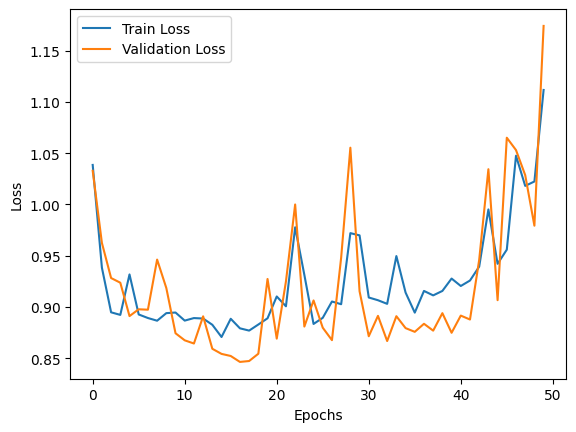

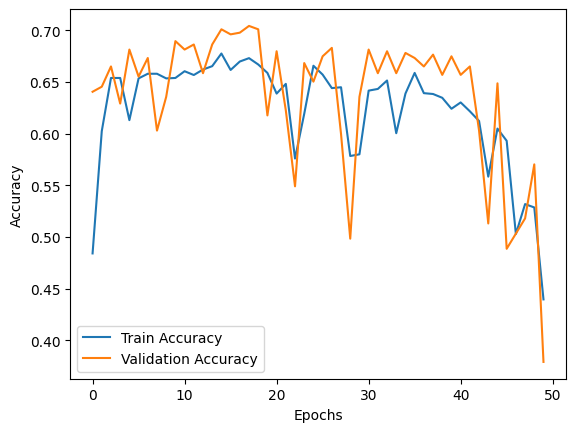

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Function to calculate accuracy
def get_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

# Training the model
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in train_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        labels = labels.cuda() if torch.cuda.is_available() else labels

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (torch.argmax(outputs, 1) == labels).sum().item()

    train_acc = correct_train / total_train
    train_accs.append(train_acc)
    train_losses.append(running_loss / len(train_loader))

    # Evaluating on validation set
    resnet_model.eval()
    val_loss = 0.0
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            total_val += labels.size(0)
            correct_val += (torch.argmax(outputs, 1) == labels).sum().item()

    val_acc = correct_val / total_val
    val_accs.append(val_acc)
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the training process
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()